# Supervised Learning
## *Finding Donors*

## Getting Started

- We will employ several supervised algorithms of our choice to accurately model individuals' income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Our goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.

- Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual's general income bracket directly from public sources, we can infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

## Exploring the Data

Code cell below is to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Importing supplementary visualization code
import visuals as vs

%matplotlib inline

# Loading the Census dataset
data = pd.read_csv("census.csv")

display(data.head(n = 10))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, We need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data.query('income == ">50K"').shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data.query('income == "<=50K"').shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**Featureset Exploration**

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Code cell below is to plot a histogram of these two features. Note the range of the values present and how they are distributed.

In [3]:
# Summary of data
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


D:\charityml\visuals.py:48: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


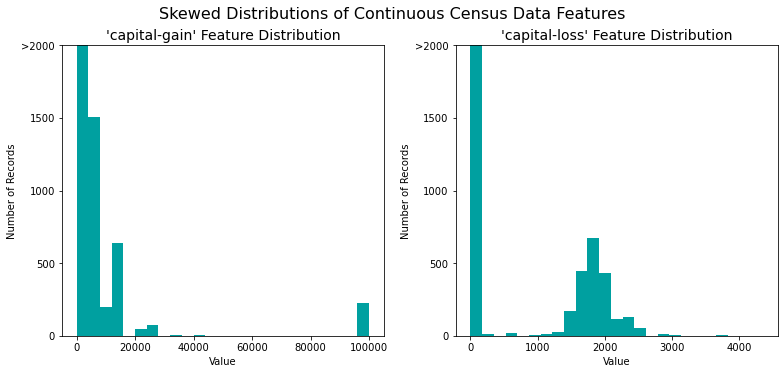

In [4]:
# Splitting the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualizing skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Code cell below is to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

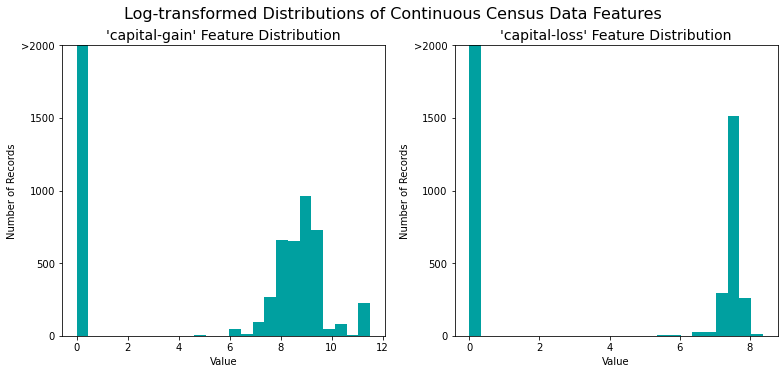

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualizing the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Code cell below is to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
features_log_transformed.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,0.740759,0.355489,40.938017
std,13.217870,2.552881,2.466527,1.595914,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,11.512925,8.379539,99.000000


In [7]:
# Importing sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initializing a scaler, then applying it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, we will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [8]:
# One-hot encoding the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encoding the 'income_raw' data to numerical values
income = pd.get_dummies(income_raw, drop_first = True)

# Printing the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# printing encoded
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [9]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

# Splitting the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size = 0.2, random_state = 0)

# Showing the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


## Evaluating Model Performance

### Metrics and the Naive Predictor
*Charity*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *Charity* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *Charity*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *Charity* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

**Accuracy** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

***General Notes***

- *Yes, accuracy is a great measure but only when you have symmetric datasets (false negatives & false positives counts are close), also, false negatives & false positives have similar costs. If the cost of false positives and false negatives are different then F1 is your savior. F1 is best if you have an uneven class distribution.*

- *Precision is how sure you are of your true positives whilst recall is how sure you are that you are not missing any positives.*

- *Choose Recall if the idea of false positives is far better than false negatives, in other words, if the occurrence of false negatives is unaccepted/intolerable, that you’d rather get some extra false positives(false alarms) over saving some false negatives, like in our diabetes example. You’d rather get some healthy people labeled diabetic over leaving a diabetic person labeled healthy.*

- *Choose precision if you want to be more confident of your true positives. for example, Spam emails. You’d rather have some spam emails in your inbox rather than some regular emails in your spam box. So, the email company wants to be extra sure that email Y is spam before they put it in the spam box and you never get to see it.*

- *Choose Specificity if you want to cover all true negatives, meaning you don’t want any false alarms, you don’t want any false positives. for example, you’re running a drug test in which all people who test positive will immediately go to jail, you don’t want anyone drug-free going to jail. False positives here are intolerable.*

***Bottom Line is***

- *Accuracy value of 90% means that 1 of every 10 labels is incorrect, and 9 is correct.*
- *Precision value of 80% means that on average, 2 of every 10 diabetic labeled student by our program is healthy, and 8 is diabetic.*
- *Recall value is 70% means that 3 of every 10 diabetic people in reality are missed by our program and 7 labeled as diabetic.*
- *Specificity value is 60% means that 4 of every 10 healthy people in reality are miss-labeled as diabetic and 6 are correctly labeled as healthy.*

### Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? Assigning our results to `'accuracy'` and `'fscore'` for later use.

**Please note** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally our base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [10]:
TP = np.sum(income)[0] # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
# encoded to numerical values done in the data preprocessing step.

FP = (income.count()[0] - TP) # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = (TP + TN)/(TP + FP + TN + FN)
recall = TP/(FN + TP)
precision = TP/(TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5**2)*(precision * recall)/((0.5**2)*precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that we may choose from:**
- [Gaussian Naive Bayes (GaussianNB)](https://machinelearningmastery.com/naive-bayes-for-machine-learning/#:~:text=This%20extension%20of%20naive%20Bayes,deviation%20from%20your%20training%20data.)

- [Decision Trees](https://medium.com/greyatom/decision-trees-a-simple-way-to-visualize-a-decision-dc506a403aeb#:~:text=A%20decision%20tree%20is%20a%20flowchart%2Dlike%20structure%20in%20which,taken%20after%20computing%20all%20attributes)

- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)

- [K-Nearest Neighbors (KNeighbors)](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761)

- Stochastic Gradient Descent Classifier (SGDC)

- Support Vector Machines (SVM)

- Logistic Regression

### Model Application
List the supervised learning models above that are appropriate for this problem that we will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**1.Guassian Naive Bayes**

- **Describe one real-world application in industry where the model can be applied?**

Naive Bayes are based on bayes theorm and is from the probabilistic classifiers. Guassian Naive bayes assumes that the continuous values for each class are distributed according to a guassian distribution. An example for using this is identifying the gender based on a person height, weight and foot size. other examples include recommendation systems, text classification, spam filters and real time predication.

- **What are the strengths of the model; when does it perform well?**
One of the main adavantages of using Naive bayes is the ability to handle to large number of features, performs well even in the prescence of irrelevant features, simplicity, scalability and a fast classifier.
- **What are the weaknesses of the model; when does it perform poorly?**
the assumption of the shape of the distribution. The independence assumption can eliminate the advantage of the interaction between the features. 

- **What makes this model a good candidate for the problem, given - what you know about the data?**
we have several features that can be assumed independet so we can use the probalastic nature of Naive bayes to calculate the probalities of relavant features only thus discard the rest of the features. also the dataset contains around 50000 records so this can be a simple and fast algorithm to use.

- **Resources:**
    - https://www.kaggle.com/afagarap/gaussian-naive-bayes-classifier
    - https://en.wikipedia.org/wiki/Naive_Bayes_classifier
    - https://www.quora.com/What-are-the-disadvantages-of-using-a-naive-bayes-for-classification
    - https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

**2. Decision Trees**

**Describe one real-world application in industry where the model can be applied?**
decision tress are used when data is split based on questions or features to derive different outputs. classify whether a set is for basketball players or ballerinas.

**What are the strengths of the model; when does it perform well?**
Robust to outliers. 
   
**What are the weaknesses of the model; when does it perform poorly?**
prone to overfitting which can be solved using ensembles

**What makes this model a good candidate for the problem, given - what you know about the data?**
the current problem contains features that can be used to splitting the data in order split the differnt income groups and can capture complex relations simply.  

**Resources:**
  - https://elitedatascience.com/machine-learning-algorithms

**3. Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)**

**Describe one real-world application in industry where the model can be applied?**
enhance the performance of decision trees for example by using random forest instead of using several different models such as bagging. decision tress are used when data is split based on questions or features to derive different outputs.

**What are the strengths of the model; when does it perform well?**
  - accurate models 
  - stable model
  - reduce the overfitting of the data
  - accomdate for the skewed features in teh data set and  introduce randomness to combat the highe variance
**What are the weaknesses of the model; when does it perform poorly?**
depending on ensemble method each combat a different issue. so for example the bagging combines base estimators to reduce overgfitting so this can increase the bias. the boosting combine several different weak learners to create one model which increase the variance but decrease the bias.
**What makes this model a good candidate for the problem, given - what you know about the data?**
we have lots of features and we want to make sure we are not overfitting the data so we can use this ensemble methods to try to find a balance between differnt models i will look into adaboost (minimize the errors by combining different learners into)and random forest(combining subset of decision trees into one to minimze overfitting).

**Resources:**
    - https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble
    - https://www.analyticsvidhya.com/blog/2015/09/questions-ensemble-modeling/
    - https://www.quora.com/What-are-the-pros-and-cons-of-bagging-versus-boosting-for-ensemble-machine-learning-techniques

**4.K-Nearest Neighbors (KNN)**

**Describe one real-world application in industry where the model can be applied?**

Hierarchical clustering algorithms — and nearest neighbor methods, in particular — are used extensively to understand and create value from patterns in retail business data.
- The modern systems are now able to use k-nearest neighbor for visual pattern recognition to scan and detect hidden packages in the bottom bin of a shopping cart at check-out. If an object is detected that’s an exact match for an object listed in the database, then the price of the spotted product could even automatically be added to the customer’s bill. While this automated billing practice is not used extensively at this time, the technology has been developed and is available for use.
- Average nearest neighbor algorithm classification and point pattern detection can be used in grocery retail to identify key patterns in customer purchasing behavior, and subsequently increase sales and customer satisfaction by anticipating customer behavior.

**What are the strengths of the model; when does it perform well?**
- No Training Period: KNN is called Lazy Learner (Instance based learning). It does not learn anything in the training period. It does not derive any discriminative function from the training data. In other words, there is no training period for it. It stores the training dataset and learns from it only at the time of making real time predictions. This makes the KNN algorithm much faster than other algorithms that require training e.g. SVM, Linear Regression etc.

- Since the KNN algorithm requires no training before making predictions, new data can be added seamlessly which will not impact the accuracy of the algorithm.

- KNN is very easy to implement. There are only two parameters required to implement KNN i.e. the value of K and the distance function (e.g. Euclidean or Manhattan etc.)

**What are the weaknesses of the model; when does it perform poorly?**
- Does not work well with large dataset: In large datasets, the cost of calculating the distance between the new point and each existing points is huge which degrades the performance of the algorithm.

- Does not work well with high dimensions: The KNN algorithm doesn't work well with high dimensional data because with large number of dimensions, it becomes difficult for the algorithm to calculate the distance in each dimension.

- Need feature scaling: We need to do feature scaling (standardization and normalization) before applying KNN algorithm to any dataset. If we don't do so, KNN may generate wrong predictions.

- Sensitive to noisy data, missing values and outliers: KNN is sensitive to noise in the dataset. We need to manually impute missing values and remove outliers.

**What makes this model a good candidate for the problem, given - what you know about the data?**
we have several features that can be assumed independent so we can use the classification nature of KNN to calculate the nearest of relavant features only thus discard the rest of the features. also the dataset contains around 50000 records so this can be a simple and fast algorithm to use.

**Resources:**
    - http://theprofessionalspoint.blogspot.com/2019/02/advantages-and-disadvantages-of-knn.html

**5. Stochastic Gradient Descent Classifier (SGDC)**

**Describe one real-world application in industry where the model can be applied?**
SGDC are used when data is split based on a line and we have to minimize error. Classify whether a set is for basketball players or ballerinas by using a line to divide the data.

**What are the strengths of the model; when does it perform well?**
It is fast.
   
**What are the weaknesses of the model; when does it perform poorly?**
Underfitting and less accurate.

**What makes this model a good candidate for the problem, given - what you know about the data?**
Suppose, you have a million samples in your dataset, so if you use a typical Gradient Descent optimization technique, you will have to use all of the one million samples for completing one iteration while performing the Gradient Descent, and it has to be done for every iteration until the minima is reached. Hence, it becomes computationally very expensive to perform.  

**Resources:**
  - https://stepupanalytics.com/gradient-descent-relating-it-with-real-life-analogies/

**6. Support Vector Machines (SVM)**

**Describe one real-world application in industry where the model can be applied?**
- Face detection – SVMc classify parts of the image as a face and non-face and create a square boundary around the face.
- Text and hypertext categorization – SVMs allow Text and hypertext categorization for both inductive and transductive models. They use training data to classify documents into different categories. It categorizes on the basis of the score generated and then compares with the threshold value.
- Classification of images – Use of SVMs provides better search accuracy for image classification. It provides better accuracy in comparison to the traditional query-based searching techniques.
- Bioinformatics – It includes protein classification and cancer classification. We use SVM for identifying the classification of genes, patients on the basis of genes and other biological problems.
- Protein fold and remote homology detection – Apply SVM algorithms for protein remote homology detection.
- Handwriting recognition – We use SVMs to recognize handwritten characters used widely.
- Generalized predictive control(GPC) – Use SVM based GPC to control chaotic dynamics with useful parameters.

**What are the strengths of the model; when does it perform well?**
- SVM works relatively well when there is clear margin of separation between classes.
- SVM is more effective in high dimensional spaces.
- SVM is effective in cases where number of dimensions is greater than the number of samples.
- SVM is relatively memory efficient
**What are the weaknesses of the model; when does it perform poorly?**
- SVM algorithm is not suitable for large data sets.
- SVM does not perform very well, when the data set has more noise i.e. target classes are overlapping.
- In cases where number of features for each data point exceeds the number of training data sample , the SVM will under perform.
- As the support vector classifier works by putting data points, above and below the classifying hyper plane there is no probabilistic explanation for the classification.
**What makes this model a good candidate for the problem, given - what you know about the data?**
we have lots of features and we want to make sure we are not overfitting and underfiiting the data so we can use SVM to gain control on the model and classifier to find a balance and due to high efficiency and control we will be using this.

- Resources:
    - https://medium.com/@dhiraj8899/top-4-advantages-and-disadvantages-of-support-vector-machine-or-svm-a3c06a2b107

**7. Logistic Regression**

**Describe one real-world application in industry where the model can be applied?**
Regressions can be used in real world applications such as :
- Credit Scoring
- Measuring the success rates of marketing campaigns
- Predicting the revenues of a certain product
- Is there going to be an earthquake on a particular day? etc.

**What are the strengths of the model; when does it perform well?**
It is a widely used technique because it is very efficient, does not require too many computational resources, it’s highly interpretable, it doesn’t require input features to be scaled, it doesn’t require any tuning, it’s easy to regularize, and it outputs well-calibrated predicted probabilities.
Logistic regression does work better when you remove attributes that are unrelated to the output variable as well as attributes that are very similar (correlated) to each other. Therefore Feature Engineering plays an important role in regards to the performance of Logistic and also Linear Regression.
Because of its simplicity and the fact that it can be implemented relatively easy and quick, Logistic Regression is also a good baseline that you can use to measure the performance of other more complex Algorithms.
   
**What are the weaknesses of the model; when does it perform poorly?**
Logistic Regression is also not one of the most powerful algorithms out there and can be easily outperformed by more complex ones.
Also, we can’t solve non-linear problems with logistic regression since it’s decision surface is linear.
Logistic regression will not perform well with independent variables that are not correlated to the target variable and are very similar or correlated to each other.

**What makes this model a good candidate for the problem, given - what you know about the data?**
Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary).  Like all regression analyses, the logistic regression is a predictive analysis.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables. 

**Resources:**
  - https://towardsdatascience.com/real-world-implementation-of-logistic-regression-5136cefb8125#:~:text=of%20Logistic%20Regression-,Logistic%20Regression,used%20for%20cancer%20detection%20problems.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model we've chosen, it's important that we create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Our implementation here will be used in the following section.
In the code block below, we will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [11]:
# Importing two metrics from sklearn - fbeta_score and accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size].values.ravel())
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #     then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta = 0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, we will need to implement the following:
- Import the supervised learning models we've discussed in the previous section.
- Initialize the models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms we chose, the following implementation may take some time to run!

In [12]:
# Importing the supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import fbeta_score, accuracy_score 
from xgboost import XGBClassifier

# Initialize the models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state = 42)
clf_C = BaggingClassifier(random_state = 42)
clf_D = AdaBoostClassifier(random_state = 42)
clf_E = RandomForestClassifier(random_state = 42)
clf_F = GradientBoostingClassifier(random_state = 42)
clf_G = SVC(random_state = 42)
clf_H = KNeighborsClassifier()
clf_I = SGDClassifier(random_state = 42)
clf_J = LogisticRegression(max_iter = 1000)
clf_K = XGBClassifier()

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 is the entire training set i.e. len(y_train)
# samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(0.10 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_G, clf_H, clf_I, clf_J, clf_K]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the supervised learning models chosen
# Uncomment following line for visuals
#vs.evaluate(results, accuracy, fscore)

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
BaggingClassifier trained on 361 samples.
BaggingClassifier trained on 3617 samples.
BaggingClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighbor

In [13]:
# printing test accuracy
test_results = pd.DataFrame(columns = ['Model', 'f_score_train', 'f_score_test', 'test_accuracy_100'
                                      , 'train_accuracy_100', 'train_time', 'pred_time'])
"""
How to access the nested dictionary 
for item in results:
    print("{} : accuracy for data with 1 % sample size is {}".format(item, results[item][0]['acc_test']))
    print("{} : accuracy for data with 10 % sample size is {}".format(item, results[item][1]['acc_test']))
    print("{} : accuracy for data with 100 % sample size is {}".format(item, results[item][2]['acc_test']))
"""
models = []
f_score_train = []
f_score_test = []
test_accuracy100 = []
train_accuracy_100 = []
train_time = []
pred_time = []

for item in results:
    models.append(item)
    f_score_train.append(results[item][2]['f_train'])
    f_score_test.append(results[item][2]['f_test'])
    test_accuracy100.append(results[item][2]['acc_test'])
    train_accuracy_100.append(results[item][2]['acc_train'])
    train_time.append(results[item][2]['train_time'])
    pred_time.append(results[item][2]['pred_time'])

# Appending to data frame
test_results['Model'] = models
test_results['f_score_train'] = f_score_train
test_results['f_score_test'] = f_score_test
test_results['test_accuracy_100'] = test_accuracy100
test_results['train_accuracy_100'] = train_accuracy_100
test_results['train_time'] = train_time
test_results['pred_time'] = pred_time

# Results
test_results

,Model,f_score_train,f_score_test,test_accuracy_100,train_accuracy_100,train_time,pred_time
0,GaussianNB,0.412500,0.420899,0.597678,0.593333,0.105225,0.031955
1,DecisionTreeClassifier,0.963855,0.627948,0.818574,0.970000,0.347890,0.011986
2,BaggingClassifier,0.959302,0.682927,0.842897,0.973333,3.539732,0.099863
3,AdaBoostClassifier,0.711538,0.724551,0.857601,0.850000,2.608516,0.187750
4,RandomForestClassifier,0.970588,0.681346,0.842344,0.976667,4.963212,0.191742
5,GradientBoostingClassifier,0.734127,0.739534,0.863018,0.856667,6.287048,0.023976
6,SVC,0.716912,0.685054,0.842344,0.853333,86.198644,14.661588
7,KNeighborsClassifier,0.771605,0.639164,0.823549,0.883333,1.579428,21.299749
8,SGDClassifier,0.714286,0.679201,0.840685,0.853333,0.440655,0.011957
9,LogisticRegression,0.698529,0.682929,0.841791,0.846667,1.443290,0.011983


## Improving Results
In this final section, we will choose from the supervised learning models the *best* model to use on the student data. We will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Choosing the Best Model

* Based on the evaluation we performed earlier, in one to two paragraphs, explain to *Charity* which models we believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 
 
Look at the graph if created at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

*From above results, we can choose the models with high accuracy with testing data and who fits the training data very well. We can also check high fscore as we have taken **beta = 0.5** which means we want to consider precision over recall which means we want to check how many we correctly classified from the total positive classified by our models.*

*From the above results, we see that **ensemble methods have high metrics and less training and prediction time but also SVC did well but with high training and prediction time and SGCD and Logistic regression did well too with about 84% accuracy**.*

We will be choosing Random Forest Classifier because it did great on the training data with high F-Score with precision and with high training accuracy. Also, it has great accuracy and F-Score on testing data.

### Describing the Model in Layman's Terms

In one to two paragraphs, explain to *Charity*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

 Random Forest Classifier is an ensemble machine learning algorithm and one of the best algorithm to predict data. It uses multiple features and make multiple decision trees to predict the most common or higher occuring prediction for the data.

Random Forest Classifiers is a bagging technique which uses multiple estimators or learners which provide their feedback or prediction and the most common predictions are taken.

*The fundamental concept behind random forest is a simple but powerful one — the wisdom of crowds. In data science speak, the reason that the random forest model works so well is* **A large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models.**

Random Forest Classifier provides high training accuracy which means it trains well and learns well from the data and as you can see, if the model learns well and has high accuracy and precison, therefore it is going to predict the most accurate or favourable data.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [14]:
# Importing 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initializing the classifier
clf = RandomForestClassifier(random_state = 42)

# Creating the parameters list you wish to tune, using a dictionary if needed.
# parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {
    'max_features': [1, 2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [100, 200, 300, 1000]
}

# Making an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scorer)

# Fitting the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train.values.ravel())

# Getting the estimator
best_clf = grid_fit.best_estimator_

# Making predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Displaying the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass scoring=make_scorer(fbeta_score, beta=0.5) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\Shubham\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Unoptimized model
------
Accuracy score on testing data: 0.8423
F-score on testing data: 0.6813

Optimized Model
------
Final accuracy score on the testing data: 0.8471
Final F-score on the testing data: 0.7118


### Final Model Evaluation

* What is our optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from our optimized model compare to the naive predictor benchmarks we found earlier?

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |     84.2          |    0.68         |
| F-score        |     84.8          |    0.712        |


The Scores after optimization doesn't create much difference however, our precision improved with slight increase in accuracy.

As compared to the naive predictor, our new model Random Forest is a lot better with high accuracy and F-Score.

## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


***According to me, age, workclass, occupation, sex, race, education_level and education_level are the most important features for prediction however, there might be a collinearity or multi-collinearity between features which can't be ignored.***

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, we will implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

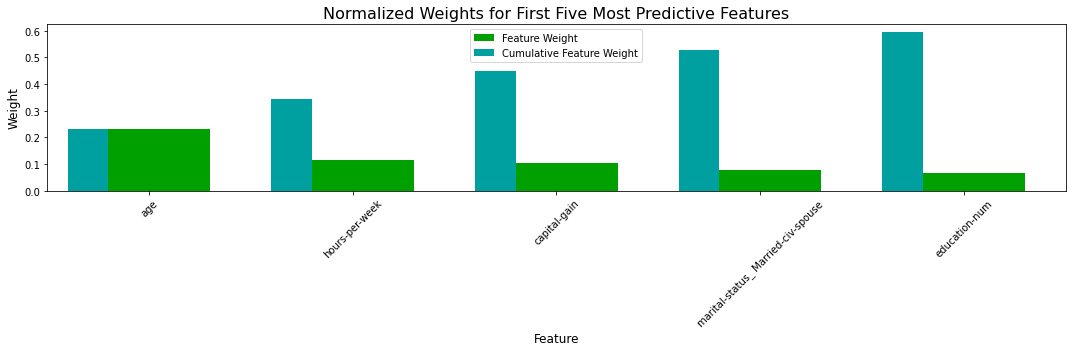

In [16]:
# Importing a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# Training the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier(random_state = 42).fit(X_train, y_train.values.ravel())

# Extracting the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plotting
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

***Some of the features i selected are shown in above graph however, many features i selected have less important but thry are related to the features in the graph, i think multicollinearity is happening here and model might have taken care of that.***

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [17]:
# Importing functionality for cloning a model
from sklearn.base import clone

# Reducing the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Training on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train.values.ravel())

# Making new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Reporting scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8471
F-score on testing data: 0.7118

Final Model trained on reduced data
------
Accuracy on testing data: 0.8458
F-score on testing data: 0.6933


### Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would we consider using the reduced data as our training set?

- ***Final model score with only top five important features reduced the Fbeta Score and reduced the accuarcy. THis means top five important features are not enough and our model have considered other features too and are also important.***

- ***If training time was a factor, yes i will be using reduced data for our training set, this may lead to less training accuracy but it will save resources and doesn't make much of a difference as accuracy gets constant for a model after certain sample size and increase in very low amount.***